In [107]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from graphviz import Source
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
import xgboost as xgb


## Preparation 

this part is from week 4 homework

In [106]:
df = pd.read_parquet('s3://datasets/github/gastonstat/CreditScoring/CreditScoring.parquet', storage_options={
    'profile': 'local',
    'client_kwargs': {
        'endpoint_url': 'http://192.168.46.220:9000'
    }
})
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [3]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [4]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [5]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [6]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Train

In [7]:
# helper function
def predict_score(clf, df_X, y):
    y_hat = clf.predict_proba(df_X)[:, 1]
    return roc_auc_score(y, y_hat)

In [19]:
def evaluate_grid(clf, df_train, y_train, df_val, y_val, grid, **kwargs):
    records = []
    for param in ParameterGrid(grid):
        tmp_clf = clf.set_params(**param)
        tmp_clf.fit(df_train, y_train, **kwargs)
        record = dict(**param)
        record['roc_auc'] = predict_score(tmp_clf, df_val, y_val)
        records.append(record)
    df_scores = pd.DataFrame.from_dict(records)
    return df_scores

### Single Treea, baseline model

In [8]:
df = df.fillna(0)

In [9]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['default'])
df_val, df_test = train_test_split(df_test, test_size=0.5, stratify=df_test['default'])

In [10]:
y_train = df_train['default'].values
y_val = df_val['default'].values
y_test = df_test['default'].values

del df_train['default']
del df_val['default']
del df_test['default']

In [12]:
categorical_cols = df_train.columns[df_train.dtypes == 'object'].to_list()
numerical_cols = df_train.columns[df_train.dtypes != 'object'].to_list()

In [13]:
ct = ColumnTransformer([
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
    ],
    remainder='passthrough'
)

clf = Pipeline([
    ('ct', ct), 
    ('estimator', DecisionTreeClassifier(random_state=42))
])

In [14]:
clf.fit(df_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['home', 'marital', 'records',
                                                   'job'])])),
                ('estimator', DecisionTreeClassifier(random_state=42))])

In [15]:
predict_score(clf, df_val, y_val), predict_score(clf, df_train, y_train)

(0.646625, 0.999999805271685)

It's obivous that we have overfitting.

If tree tree size is small, we can visualize with following

In [93]:
# code = export_graphviz(clf._final_estimator, feature_names=clf[:-1].get_feature_names_out())
# Source(code, format='svg')

#### Tuning model parameters

one at a time

In [17]:
clf2 = Pipeline([
    ('ct', ct), 
    ('estimator', DecisionTreeClassifier(random_state=42))
])

In [18]:
## we can get all parameters with this command
# clf2.get_params()

grid = dict(
    estimator__max_depth=[1, 2, 3, 4, 5, 6, 10, 15, 20, None],
)

In [20]:
df_scores = evaluate_grid(clf, df_train, y_train, df_val, y_val, grid)
df_scores.sort_values('roc_auc', ascending=False).head(5).round(3)

,estimator__max_depth,roc_auc
5,6.0,0.760
4,5.0,0.731
2,3.0,0.714
3,4.0,0.707
1,2.0,0.685


max_depth = [4, 5 ,6] looks nice.

In [21]:
grid = dict(
    estimator__max_depth=[4, 5, 6],
    estimator__min_samples_leaf=[1, 2, 5, 10, 15, 20, 100, 200, 500]
)
df_scores = evaluate_grid(clf2, df_train, y_train, df_val, y_val, grid)
df_scores.sort_values('roc_auc', ascending=False).head(5).round(3)

,estimator__max_depth,estimator__min_samples_leaf,roc_auc
22,6,15,0.777
21,6,10,0.775
25,6,200,0.771
23,6,20,0.770
26,6,500,0.768


In [22]:
df_scores_pivot = df_scores.pivot(index='estimator__min_samples_leaf', columns=['estimator__max_depth'], values=['roc_auc'])
df_scores_pivot

roc_auc                    
estimator__max_depth                4         5         6
estimator__min_samples_leaf                              
1                            0.707050  0.731462  0.760375
2                            0.707050  0.731462  0.758725
5                            0.717775  0.744125  0.766025
10                           0.717775  0.739575  0.774712
15                           0.709400  0.740900  0.776612
20                           0.709188  0.740175  0.770213
100                          0.720775  0.735450  0.767400
200                          0.722725  0.738350  0.770750
500                          0.768375  0.768375  0.768375

<AxesSubplot:xlabel='None-estimator__max_depth', ylabel='estimator__min_samples_leaf'>

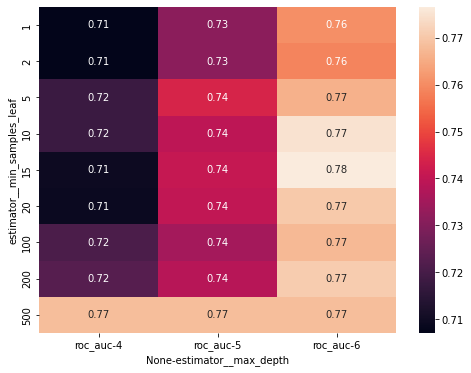

In [23]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_scores_pivot, annot=True)

So the final parameter will be
- max depth = 6
- min samples leaf = 15

In [94]:
grid = dict(
    estimator__max_depth=[6],
    estimator__min_samples_leaf=[15]
)
df_full_train = pd.concat([df_train, df_val])
y_full_train = np.hstack([y_train, y_val])
df_scores = evaluate_grid(clf2, df_full_train, y_full_train, df_test, y_test, grid)
df_scores.sort_values('roc_auc', ascending=False).head(5).round(3)

,estimator__max_depth,estimator__min_samples_leaf,roc_auc
0,6,15,0.773


On cross-validation set auc from 0.646 -> 0.776 ~ 20% increase

and we have similar result on test set

### Ensembles and random forest

In [25]:
clf3 = Pipeline([
    ('ct', ct), 
    ('estimator', RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1))
])

In [26]:
clf3.get_params()

{'memory': None,
 'steps': [('ct', ColumnTransformer(remainder='passthrough',
                     transformers=[('onehot',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['home', 'marital', 'records', 'job'])])),
  ('estimator',
   RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42))],
 'verbose': False,
 'ct': ColumnTransformer(remainder='passthrough',
                   transformers=[('onehot',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['home', 'marital', 'records', 'job'])]),
 'estimator': RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42),
 'ct__n_jobs': None,
 'ct__remainder': 'passthrough',
 'ct__sparse_threshold': 0.3,
 'ct__transformer_weights': None,
 'ct__transformers': [('onehot',
   OneHotEncoder(handle_unknown='ignore'),
   ['home', 'marital', 'records', 'job'])],
 'ct__verbose': False,
 'ct__verbose_feature_na

In [27]:
grid = dict(
    estimator__n_estimators=range(10, 201, 10)
)
df_scores = evaluate_grid(clf3, df_train, y_train, df_val, y_val, grid)

In [28]:
df_scores.sort_values('roc_auc', ascending=False).head(5).round(3)

,estimator__n_estimators,roc_auc
9,100,0.835
10,110,0.834
11,120,0.834
17,180,0.834
19,200,0.834


<AxesSubplot:xlabel='estimator__n_estimators', ylabel='roc_auc'>

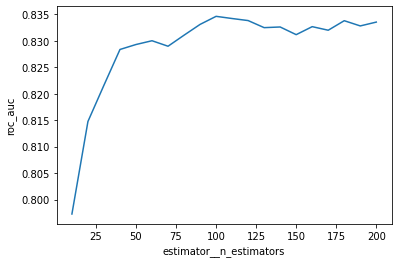

In [29]:
sns.lineplot(data=df_scores, x='estimator__n_estimators', y='roc_auc')

find optimal depth

In [30]:
grid = dict(
    estimator__n_estimators=range(10, 201, 10),
    estimator__max_depth=[5, 10, 15]
)
df_scores = evaluate_grid(clf3, df_train, y_train, df_val, y_val, grid)

In [31]:
df_scores.sort_values('roc_auc', ascending=False).head(5).round(3)

,estimator__max_depth,estimator__n_estimators,roc_auc
59,15,200,0.832
37,10,180,0.832
35,10,160,0.832
30,10,110,0.832
32,10,130,0.832


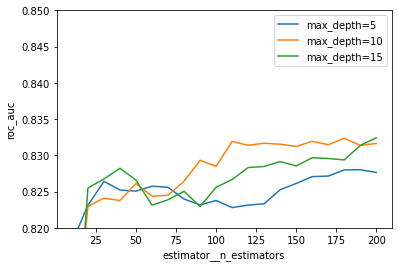

In [32]:
for d in grid['estimator__max_depth']:
    df_subset = df_scores[df_scores.estimator__max_depth == d]
    sns.lineplot(data=df_subset, x='estimator__n_estimators', y='roc_auc', label=f'max_depth={d}')
    plt.ylim(0.82, 0.85)

max_depth=10 looks ok

find optimal min samples leaf

In [33]:
grid = dict(
    estimator__n_estimators=range(10, 201, 10),
    estimator__max_depth=[10],
    estimator__min_samples_leaf=[1, 3, 5, 10, 50]
)
df_scores = evaluate_grid(clf3, df_train, y_train, df_val, y_val, grid)

In [34]:
df_scores.sort_values('roc_auc', ascending=False).head(5).round(3)

,estimator__max_depth,estimator__min_samples_leaf,estimator__n_estimators,roc_auc
31,10,3,120,0.843
32,10,3,130,0.842
30,10,3,110,0.842
33,10,3,140,0.841
29,10,3,100,0.840


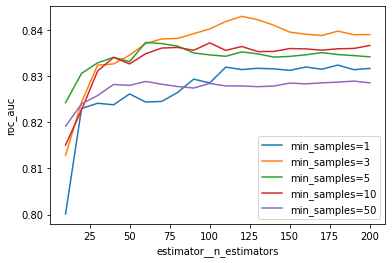

In [35]:
for s in grid['estimator__min_samples_leaf']:
    df_subset = df_scores[df_scores.estimator__min_samples_leaf == s]
    sns.lineplot(data=df_subset, x='estimator__n_estimators', y='roc_auc', label=f'min_samples={s}')

so after all, the parameters would be
- estimator = 175
- max depth = 10
- max samples leaf = 3

In [98]:
grid = dict(
    estimator__n_estimators=[175],
    estimator__max_depth=[10],
    estimator__min_samples_leaf=[3]
)
df_full_train = pd.concat([df_train, df_val])
y_full_train = np.hstack([y_train, y_val])
df_scores = evaluate_grid(clf3, df_full_train, y_full_train, df_test, y_test, grid)
df_scores.sort_values('roc_auc', ascending=False).head(5).round(3)

,estimator__max_depth,estimator__min_samples_leaf,estimator__n_estimators,roc_auc
0,10,3,175,0.824


On cross-validation set auc from 0.646 -> 0.843 ~ 30% increase

on test set, 2% drop, but still okay.

## XGboost

In [37]:
def evaluate_grid_xdgboot(clf, df_train, y_train, df_val, y_val, default_params, grid):
    record = {}
    X_train = clf.fit_transform(df_train)
    X_val = clf.transform(df_val)
    for param in ParameterGrid(grid):
        model = xgb.XGBClassifier(**default_params).set_params(**param)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        if param:
            key = '|'.join(f'{k}={v}' for k, v in param.items())
        else:
            key = 'default'
        for mname, v in model.evals_result()['validation_0'].items():
            record[key + f'_{mname}'] = v
    df_scores = pd.DataFrame.from_dict(record)
    return df_scores

In [38]:
clf4 = Pipeline([
    ('ct', ct) 
])

In [39]:
model = xgb.XGBClassifier(
    n_estimators=3,
    learning_rate=0.3,
    max_depth=6,
    min_child_weight=1,
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    verbosity=1,
    eval_metric='auc'
)

In [40]:
xgb_param = dict(
    n_estimators=200,
    learning_rate=0.3,
    max_depth=6,
    min_child_weight=1,
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42,
    verbosity=0,
    eval_metric='auc'
)

In [41]:
grid=dict(
    learning_rate=[0.01, 0.03, 0.1, 0.3, 1.0],
    # max_depth=[1, 3, 10, 30, 100, 300],
)

df_scores = evaluate_grid_xdgboot(clf4, df_train, y_train, df_val, y_val, xgb_param, grid)

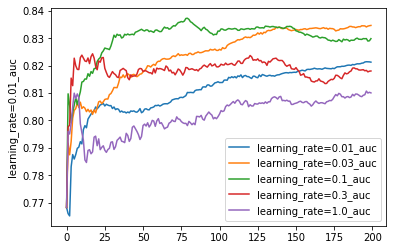

In [42]:
for label, series in df_scores.iteritems():
    sns.lineplot(x=df_scores.index, y=series, label=label)

In [72]:
grid=dict(
    learning_rate=[0.1],
    max_depth=[1, 3, 10, 30, 100, 300],
)

df_scores = evaluate_grid_xdgboot(clf4, df_train, y_train, df_val, y_val, xgb_param, grid)

(0.8, 0.85)

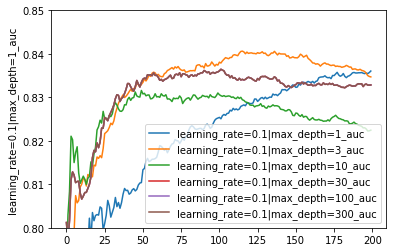

In [74]:
for label, series in df_scores.iteritems():
    sns.lineplot(x=df_scores.index, y=series, label=label)
plt.ylim(0.8, 0.85)

In [86]:
grid=dict(
    learning_rate=[0.1],
    max_depth=[300],
    min_child_weight=[1, 3, 10, 30, 100]
)
df_scores = evaluate_grid_xdgboot(clf4, df_train, y_train, df_val, y_val, xgb_param, grid)

(0.83, 0.85)

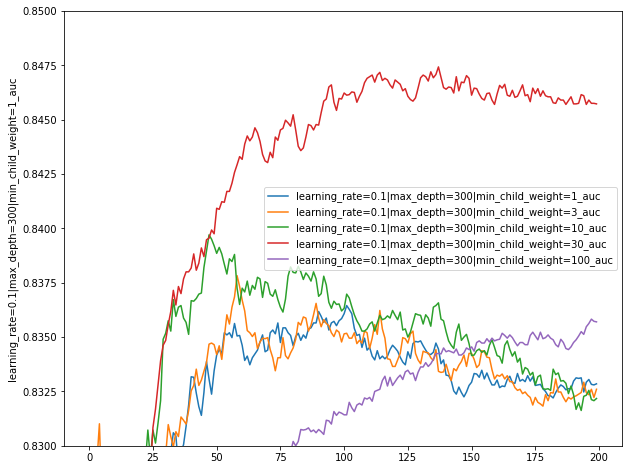

In [87]:
plt.figure(figsize=(10, 8))
for label, series in df_scores.iteritems():
    sns.lineplot(x=df_scores.index, y=series, label=label)


plt.ylim(0.83, 0.85)

final parameters
```
grid=dict(
    learning_rate=[0.1],
    max_depth=[3],
    min_child_weight=[10]
)
```

In [89]:
grid=dict(
    learning_rate=[0.1],
    max_depth=[300],
    min_child_weight=[30],
    n_estimators=[75]
)

df_full_train = pd.concat([df_train, df_val])
y_full_train = np.hstack([y_train, y_val])

df_scores = evaluate_grid_xdgboot(clf4, df_full_train, y_full_train, df_test, y_test, xgb_param, grid)

In [90]:
df_scores.tail(1)

,learning_rate=0.1|max_depth=300|min_child_weight=30|n_estimators=75_auc
74,0.840352


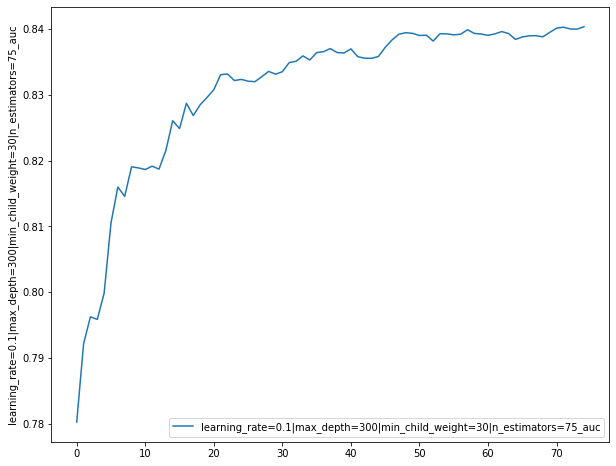

In [91]:
plt.figure(figsize=(10, 8))
for label, series in df_scores.iteritems():
    sns.lineplot(x=df_scores.index, y=series, label=label)

Compare to emsemble solution, auc inclease about 0.04~0.005 not mutch, but on test set about 0.2 incleasing.